In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

In [2]:
### Hyperparameters
USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 16
N_EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
gc.collect()

11

## Get Training Data, Rotational Test Data, and Scale Test Data

In [4]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_rotate = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomRotation((-90,90)),
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_scale_half = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                transforms.Resize(20),
                                transforms.Pad(padding=4, padding_mode='edge'),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)


## Visualize the Data

Index: 0
Example Shape: torch.Size([16, 1, 28, 28])
Target Shape : torch.Size([16])


<module 'matplotlib.pyplot' from 'C:\\Users\\PLx1105\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

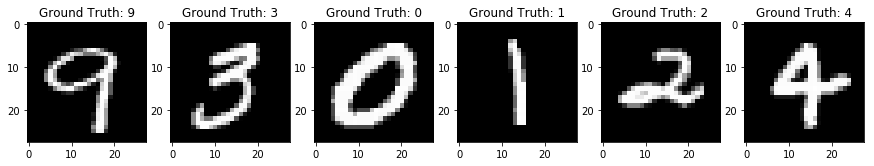

In [5]:
### Train Data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([16, 1, 28, 28])
Target Shape : torch.Size([16])


<module 'matplotlib.pyplot' from 'C:\\Users\\PLx1105\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

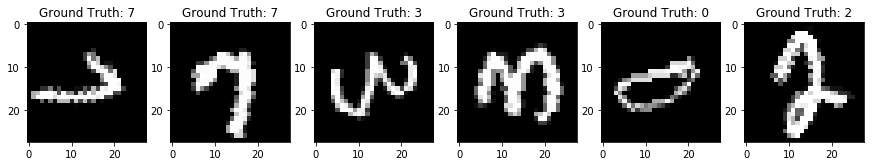

In [6]:
### Test Data Rotate
examples = enumerate(test_loader_rotate)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([16, 1, 28, 28])
Target Shape : torch.Size([16])


<module 'matplotlib.pyplot' from 'C:\\Users\\PLx1105\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

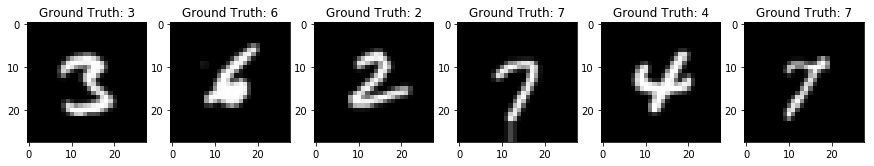

In [7]:
### Test Data Scale
examples = enumerate(test_loader_scale_half)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

In [8]:
gc.collect()

20594

# Global Functions Needed

<p>&nbsp;</p>
<h4>Squash Function from CapsNet Paper <a href="https://arxiv.org/pdf/1710.09829.pdf">[source]</a></h4>
<p><img src="https://pechyonkin.me/images/201711-capsules-2/squash.png" width="428" height="142" /></p>

<p>&nbsp;</p>
<h4>Margin Loss from CapsNet Paper <a href="https://arxiv.org/pdf/1710.09829.pdf">[source]</a></h4>
<p><img src="https://pechyonkin.me/images/201802-capsules-4/2.png" width="800" height="400" /></p>

In [9]:
def squash(input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return output_tensor

def margin_loss(x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

# Layers Needed
### Layer 1 = Convolutional Layer
<p>Input = 28x28 image (one color channel)</p>
<p>Number of Kernals = 256</p>
<p>Kernal Size = 9x9</p>
<p>Stride = 1</p>
<p>Output = 20x20x256</p>

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))

### Layer 2 = Primary Caps Layer
<p>Input = 20x20x256 tensor</p>
<p> Number of Capsules = 32</p>
<p>Kernal Size = 9x9x256</p>
<p>Stride = 2</p>
<p>Output = 6x6x9x32 tensor</p>

In [11]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return squash(u)

### Layer 3 = Digit Caps Layer
<p>Input = 6x6x8x32 tensor</p>
<p>Number of Capsules = 10 </p>

<p>Output = 16x10 matrix</p>


In [12]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)


### Decoder
<p>Input =&nbsp;16-dimensional vector from the Digit Capsule Layer</p>
<p>Output = 28x28 reconstructed image</p>
<p>Loss Function =&nbsp;&nbsp;Euclidean distance between the reconstructed image and the input image&nbsp;</p>

### Layer 4 = Fully Connected 1
<p>Input =&nbsp;16x10 flattened (160 nodes)</p>
<p>Output = 512 nodes</p>

### Layer 5 = Fully Connected 2
<p>Input 512 nodes</p>
<p>Output = 1024 nodes</p>

### Layer 6 = Fully Connected 3
<p>Input 1024 nodes</p>
<p>Output = 784 nodes (28x28)</p>

In [13]:
class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_height * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked

In [14]:
gc.collect()

0

# Construct Entire Capsule Network Model

In [15]:
class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
            self.decoder = Decoder(config.input_width, config.input_height, config.cnn_in_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()
            self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)


    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

# Train and Test Loops for the Model

In [16]:
def train(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.data
        total_loss += train_loss
        if batch_id % 100 == 0:
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                correct / float(BATCH_SIZE),
                train_loss / float(BATCH_SIZE)
                ))
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))
    
def test(capsule_net, test_loader, epoch):
    capsule_net.eval()
    test_loss = 0
    correct = 0
    for batch_id, (data, target) in enumerate(test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data[0]
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))

    tqdm.write(
        "Epoch: [{}/{}], test accuracy: {:.6f}, loss: {:.6f}".format(epoch, N_EPOCHS, correct / len(test_loader.dataset),
                                                                  test_loss / len(test_loader)))


# Run the Training

In [17]:
gc.collect()
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
#capsule_net = capsule_net.module

optimizer = torch.optim.Adam(capsule_net.parameters())

for e in range(1, N_EPOCHS + 1):
    train(capsule_net, optimizer, train_loader, e)
    test(capsule_net, test_loader_rotate, e)
    test(capsule_net, test_loader_scale_half, e)

Epoch: [1/30], Batch: [1/3750], train accuracy: 0.250000, loss: 0.056193


  1%|          | 46/3750 [01:16<2:18:53,  2.25s/it]

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:201